In [2]:
import os
os.chdir('../')
current_directory = os.getcwd()
print("Current Directory:", current_directory)
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder,StandardScaler,OneHotEncoder
from sklearn.manifold import TSNE
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import librosa
import librosa.display
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.models import load_model
from sklearn.model_selection import train_test_split
from tensorflow.keras.layers import Conv2D
from tensorflow.keras.layers import AveragePooling2D
from tensorflow.keras.layers import Reshape
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import Input
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Activation
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.layers import LSTM
import tensorflow.keras
from tensorflow.keras.callbacks import ModelCheckpoint
from sklearn.model_selection import KFold
from sklearn.metrics import roc_curve, auc
from support.attention_layer import AttentionLayer
from support.AttentionSupport import my_precision, my_recall, my_f1, my_roc_auc, get_specificity, get_balanced_acc, plotConfusionMatrix, plotCurves, progressBar, plotROCCurve

Current Directory: c:\Users\Darren Chong\Documents\School\Thesis B\Spectrogram-Based-Omics-Imagification



In [3]:
expr_file = r"./data/TCGA/curatedTCGAData_RNASeq2GeneNorm.txt"
expr = pd.read_csv(expr_file, sep="\t")
y = expr['cancer'].values
X = expr.iloc[:, 2:].values
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y)


In [4]:
def scaler_fit(X: np.ndarray) -> tuple:
    """Compute parameters needed for log normalization and scaling."""
    min0 = X.min(axis=0)
    max_val = np.log(X + np.abs(min0) + 1).max()
    return min0, max_val

def scaler_transform(X: np.ndarray, min0: np.ndarray, max_val: float) -> np.ndarray:
    """Apply log normalization and scaling to the input data."""
    X_norm = np.log(X + np.abs(min0) + 1).clip(0, None)
    return (X_norm / max_val).clip(0, 1)

def scaler_fit_transform(X: np.ndarray) -> np.ndarray:
    """Combine fitting and transforming steps."""
    min0, max_val = scaler_fit(X)
    return (scaler_transform(X, min0, max_val), min0, max_val)

(X_train_norm, min0, max_val) = scaler_fit_transform(X_train)
X_test_norm = scaler_transform(X_test, min0, max_val)

le = LabelEncoder()
y_train_enc = le.fit_transform(y_train)
y_test_enc = le.transform(y_test)

num_classes = np.unique(y_train_enc).size
ohe = OneHotEncoder(sparse=False)
y_train_ohe = ohe.fit_transform(y_train_enc.reshape(-1, 1))
y_test_ohe = ohe.transform(y_test_enc.reshape(-1, 1))

c:\Programs\Anaconda3\envs\py310\lib\site-packages\sklearn\preprocessing\_encoders.py:975: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


In [5]:
distance_metric = 'cosine'
reducer = TSNE(
    n_components=1,
    metric=distance_metric,
    init='random',
    learning_rate='auto',
    n_jobs=-1
)
X_embedded = reducer.fit_transform(X_train_norm.T)

indexed_list = list(enumerate(X_embedded))
# Sort the indexed list by value
sorted_indexed_list = sorted(indexed_list, key=lambda x: x[1])
sorted_indices = [index for index, _ in sorted_indexed_list]

In [6]:
sampling_rate = 1000  # Hz
window_length = 256
overlap = 128

def compute_log_mel_spectrogram(y, sr):
    n_fft = 512
    hop_length = 256
    D = librosa.stft(y, n_fft=n_fft, hop_length=hop_length)
    spectrogram = np.abs(D)
    n_mels = 64
    mel_spectrogram = librosa.feature.melspectrogram(S=spectrogram, sr=sr, n_fft=n_fft, hop_length=hop_length, n_mels=n_mels)
    log_mel_spectrogram = librosa.power_to_db(mel_spectrogram, ref=np.max)
    return log_mel_spectrogram

# Function to standardize spectrogram
def standardize_spectrogram(log_mel_spectrogram, global_mean, global_std):
    scaler = StandardScaler()
    scaler.mean_ = global_mean
    scaler.scale_ = global_std
    standardized_spectrogram = scaler.transform(log_mel_spectrogram.T).T  # Transpose for correct standardization
    return standardized_spectrogram

concatenated = np.concatenate([compute_log_mel_spectrogram(X_train_norm[i], sampling_rate).T for i in range(X_train_norm.shape[0])], axis=0)
global_mean = np.mean(concatenated, axis=0)
global_std = np.std(concatenated, axis=0)
np.save('./TCGA/global_mean.npy', global_mean)
np.save('./TCGA/global_std.npy', global_std)

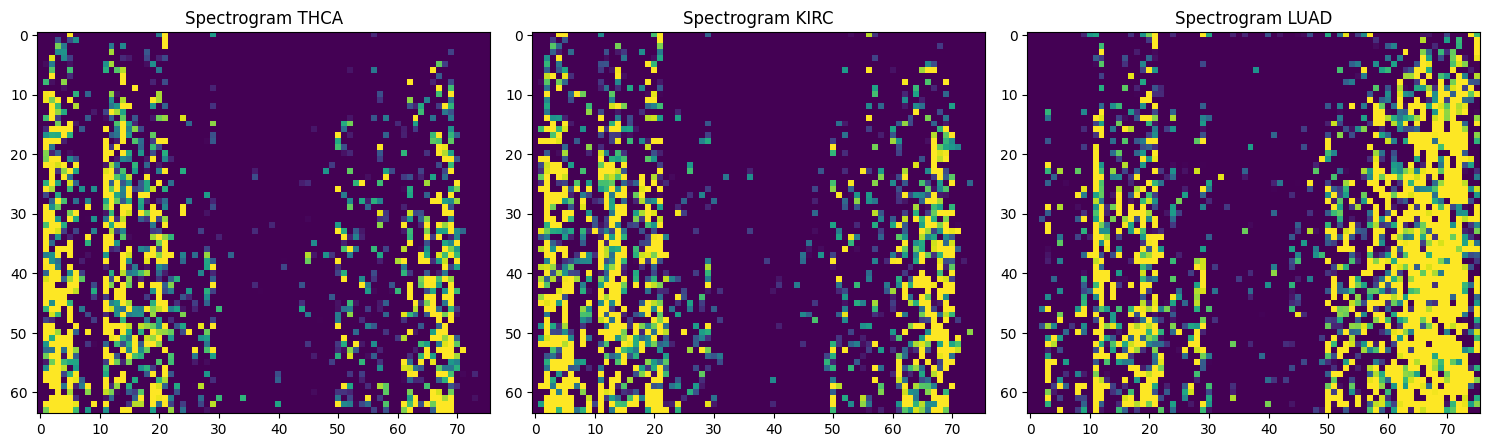

In [7]:
# Initialize an empty list to store the wavelet spectrograms
wavelet_spectrograms_train = []

for i in range(X_train_norm.shape[0]):
    sorted_train = np.array([X_train_norm[i][m] for m in sorted_indices])
    log_mel_spectrogram = compute_log_mel_spectrogram(sorted_train, sampling_rate)
    standardized_spectrogram = standardize_spectrogram(log_mel_spectrogram, global_mean, global_std)
    
    # Convert standardized spectrogram to RGB image using viridis color map
    rgb_image = plt.cm.viridis(standardized_spectrogram)[:, :, :3]

    # Append to the list of wavelet spectrograms
    wavelet_spectrograms_train.append(rgb_image)

# Convert the list to a NumPy array
wavelet_spectrograms_train = np.array(wavelet_spectrograms_train)
# Plot the wavelet spectrograms
fig, ax = plt.subplots(1, 3, figsize=(15, 5))
for i in range(0,3):
    ax[i].imshow(wavelet_spectrograms_train[i])
    ax[i].title.set_text('Spectrogram {}'.format(y_test[i]))

plt.tight_layout()

# Initialize an empty list to store the wavelet spectrograms
wavelet_spectrograms_test = []

# Apply wavelet transform for each row in the data
for i in range(X_test_norm.shape[0]):
    sorted_test = np.array([X_test_norm[i][m] for m in sorted_indices])
    log_mel_spectrogram = compute_log_mel_spectrogram(sorted_test, sampling_rate)
    standardized_spectrogram = standardize_spectrogram(log_mel_spectrogram, global_mean, global_std)
    
    # Convert standardized spectrogram to RGB image using viridis color map
    rgb_image = plt.cm.viridis(standardized_spectrogram)[:, :, :3]

    wavelet_spectrograms_test.append(rgb_image)
# Convert the list to a NumPy array
wavelet_spectrograms_test = np.array(wavelet_spectrograms_test)

In [8]:
trainX = wavelet_spectrograms_train
trainY = le.fit_transform(y_train)

testX  = wavelet_spectrograms_test
testY = le.transform(y_test)


In [20]:
input_shape = (64, 76,3)

METRICS = [
    tensorflow.keras.metrics.BinaryAccuracy(name='accuracy'),
    tensorflow.keras.metrics.Precision(name='precision'),
    tensorflow.keras.metrics.Recall(name='recall'),
    tensorflow.keras.metrics.AUC(name='AUC')
]

epochs = 500
batch_size = 256
learning_rate = 0.001
optimizer = tensorflow.keras.optimizers.Adamax(learning_rate = learning_rate)
filepath="./TCGA/weights/model_best_weights"+".hdf5"    
checkpoint = ModelCheckpoint(filepath, monitor='val_accuracy', verbose=1, save_best_only=True, mode='max')

###### Model architecture
inputs = Input(shape=input_shape, name='input')
x = Conv2D(16, (2, 2), strides=(1, 1), padding='valid', kernel_initializer='normal')(inputs)
x = AveragePooling2D((2, 2), strides=(1, 1))(x)
x = BatchNormalization()(x)
x = Activation('relu')(x)
x = Dropout(0.2)(x)
x = Conv2D(32, (2, 2), strides=(1, 1), padding="valid", kernel_initializer='normal')(x)
x = AveragePooling2D((2, 2), strides=(1, 1))(x)
x = BatchNormalization()(x)
x = Activation('relu')(x)
x = Dropout(0.2)(x)
x = Conv2D(64, (2, 2), strides=(1, 1), padding="valid", kernel_initializer='normal')(x)
x = AveragePooling2D((2, 2), strides=(1, 1))(x)
x = BatchNormalization()(x)
x = Activation('relu')(x)
x = Dropout(0.2)(x)
x = Conv2D(128, (2, 2), strides=(1, 1), padding="valid", kernel_initializer='normal')(x)
x = AveragePooling2D((2, 2), strides=(1, 1))(x)
x = BatchNormalization()(x)
x = Activation('relu')(x)
x = Dropout(0.2)(x)
td = Reshape([56,68*128])(x)
x = LSTM(256, return_sequences=True)(td)
x = Activation('tanh')(x)
x = BatchNormalization()(x)
x = Dropout(0.2)(x)
x = AttentionLayer(return_sequences=False)(x)
x = Dense(100)(x)
x = Activation('relu')(x)
x = Dropout(0.5)(x)
x = Dense(num_classes, name='output_layer')(x)
x = Activation('softmax')(x)
model = Model(inputs=inputs, outputs=x)
model.compile(optimizer=optimizer, loss="categorical_crossentropy", metrics=METRICS)
    
history = model.fit(wavelet_spectrograms_train, y_train_ohe, batch_size=batch_size, epochs=epochs, validation_split=0.1, verbose=2, callbacks=[checkpoint])

# Evaluate the model on the test data
covPredict = model.predict(wavelet_spectrograms_test)
test_predicted = np.where(covPredict >= 0.5, 1, 0)
y_test_tensor = y_test_ohe

trainPredict = model.predict(wavelet_spectrograms_train)
train_predicted = np.where(trainPredict >= 0.5, 1, 0)
y_train_tensor = y_train_ohe

Epoch 1/500

Epoch 1: val_accuracy improved from -inf to 0.85714, saving model to ./TCGA/weights\model_best_weights.hdf5
12/12 - 39s - loss: 0.7507 - accuracy: 0.9371 - precision: 0.8916 - recall: 0.6370 - AUC: 0.9528 - val_loss: 2.0363 - val_accuracy: 0.8571 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_AUC: 0.4995 - 39s/epoch - 3s/step
Epoch 2/500


C:\Users\Darren Chong\AppData\Roaming\Python\Python310\site-packages\keras\src\engine\training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(



Epoch 2: val_accuracy did not improve from 0.85714
12/12 - 35s - loss: 0.2374 - accuracy: 0.9799 - precision: 0.9493 - recall: 0.9079 - AUC: 0.9940 - val_loss: 2.1605 - val_accuracy: 0.8571 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_AUC: 0.4779 - 35s/epoch - 3s/step
Epoch 3/500

Epoch 3: val_accuracy did not improve from 0.85714
12/12 - 35s - loss: 0.1750 - accuracy: 0.9853 - precision: 0.9636 - recall: 0.9322 - AUC: 0.9965 - val_loss: 2.1794 - val_accuracy: 0.8571 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_AUC: 0.5061 - 35s/epoch - 3s/step
Epoch 4/500

Epoch 4: val_accuracy did not improve from 0.85714
12/12 - 35s - loss: 0.1517 - accuracy: 0.9868 - precision: 0.9621 - recall: 0.9448 - AUC: 0.9971 - val_loss: 2.1659 - val_accuracy: 0.8571 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_AUC: 0.5202 - 35s/epoch - 3s/step
Epoch 5/500

Epoch 5: val_accuracy did not improve from 0.85714
12/12 - 35s - loss: 0.1287 - accuracy: 0.9893 - precision: 0

Training Accuracy: 0.996709542327251
Test Accuracy: 0.9712918660287081
Precision (Macro): 0.9668900933264546
Precision (Micro): 0.9712918660287081
Precision (Weighted): 0.9731643528987187
Recall (Macro): 0.9759356306355047
Recall (Micro): 0.9712918660287081
Recall (Weighted): 0.9712918660287081
F1-score (Macro): 0.9706914627956112
F1-score (Micro): 0.9712918660287081
F1-score (Weighted): 0.9715666792221956
ROC-AUC (OvO, Macro): 0.9970540886468353
ROC-AUC (OvO, Weighted): 0.9973543430009396
ROC-AUC (OvR, Macro): 0.9970540886468353
ROC-AUC (OvR, Weighted): 0.9973543430009396

Classification Report:
              precision    recall  f1-score   support

           0       1.00      0.95      0.97       230
           1       0.95      1.00      0.98        99
           2       1.00      1.00      1.00       107
           3       1.00      1.00      1.00       103
           4       0.97      0.92      0.94       109
           5       0.86      0.97      0.91        89
           6     

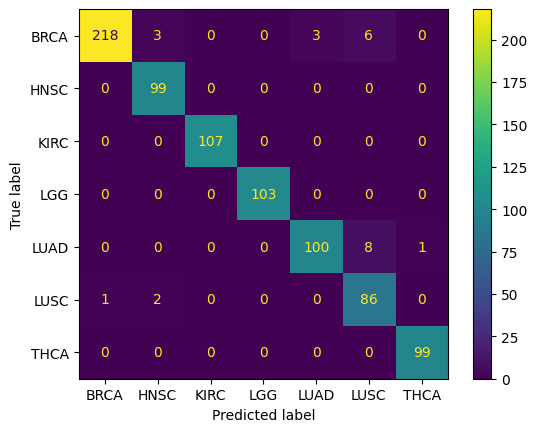

In [40]:
from sklearn.metrics import precision_score, recall_score, f1_score, roc_auc_score, classification_report, confusion_matrix, accuracy_score, ConfusionMatrixDisplay

# Calculate precision with 'macro' average
precision_macro = precision_score(test_predicted, y_test_tensor, average='macro')

# Calculate precision with 'micro' average
precision_micro = precision_score(test_predicted, y_test_tensor, average='micro')

# Calculate precision with 'weighted' average
precision_weighted = precision_score(test_predicted, y_test_tensor, average='weighted')

# Calculate recall with 'macro' average
recall_macro = recall_score(test_predicted, y_test_tensor, average='macro')

# Calculate recall with 'micro' average
recall_micro = recall_score(test_predicted, y_test_tensor, average='micro')

# Calculate recall with 'weighted' average
recall_weighted = recall_score(test_predicted, y_test_tensor, average='weighted')

# Calculate F1-score with 'macro' average
f1_macro = f1_score(test_predicted, y_test_tensor, average='macro')

# Calculate F1-score with 'micro' average
f1_micro = f1_score(test_predicted, y_test_tensor, average='micro')

# Calculate F1-score with 'weighted' average
f1_weighted = f1_score(test_predicted, y_test_tensor, average='weighted')

# Calculate ROC-AUC score with One-vs-One (OvO) strategy
roc_auc_ovo_macro = roc_auc_score(y_test_tensor, covPredict, multi_class='ovo', average='macro')
roc_auc_ovo_weighted = roc_auc_score(y_test_tensor, covPredict, multi_class='ovo', average='weighted')

# Calculate ROC-AUC score with One-vs-Rest (OvR) strategy
roc_auc_ovr_macro = roc_auc_score(y_test_tensor, covPredict, multi_class='ovr', average='macro')
roc_auc_ovr_weighted = roc_auc_score(y_test_tensor, covPredict, multi_class='ovr', average='weighted')

# Classification report (includes precision, recall, F1-score, support)
report = classification_report(test_predicted, y_test_tensor)

train_accuracy = accuracy_score(train_predicted, y_train_tensor)


# Calculate test accuracy
test_accuracy = accuracy_score(test_predicted, y_test_tensor )
print("Training Accuracy:", train_accuracy)
print("Test Accuracy:", test_accuracy)
print("Precision (Macro):", precision_macro)
print("Precision (Micro):", precision_micro)
print("Precision (Weighted):", precision_weighted)
print("Recall (Macro):", recall_macro)
print("Recall (Micro):", recall_micro)
print("Recall (Weighted):", recall_weighted)
print("F1-score (Macro):", f1_macro)
print("F1-score (Micro):", f1_micro)
print("F1-score (Weighted):", f1_weighted)
print("ROC-AUC (OvO, Macro):", roc_auc_ovo_macro)
print("ROC-AUC (OvO, Weighted):", roc_auc_ovo_weighted)
print("ROC-AUC (OvR, Macro):", roc_auc_ovr_macro)
print("ROC-AUC (OvR, Weighted):", roc_auc_ovr_weighted)
print("\nClassification Report:")
print(report)
disp = ConfusionMatrixDisplay.from_predictions(test_predicted.argmax(axis=1), y_test_tensor.argmax(axis=1), display_labels=le.classes_)